In [6]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
from sklearn.preprocessing import StandardScaler,OneHotEncoder


In [7]:
pd.options.display.max_columns=None

In [8]:
data_file = "../data/Dataset.xlsx"
path = Path(data_file)
assert path.exists(), "Data file does not exist"

In [9]:
client_demographics = pd.read_excel(path, sheet_name='Soc_Dem')
client_products = pd.read_excel(path, sheet_name='Products_ActBalance')
client_inflow_outflow = pd.read_excel(path, sheet_name='Inflow_Outflow')
client_sales_rev = pd.read_excel(path, sheet_name='Sales_Revenues')

# Analyzing client_demographics

In [10]:
# Identify missing values if any
client_demographics.isna().any()

Client    False
Sex        True
Age       False
Tenure    False
dtype: bool

In [11]:
# Identify rows where Sex is NaN
clients_Sex_Nan = np.where(client_demographics.Sex.isna())
print(clients_Sex_Nan)
display(client_demographics.loc[clients_Sex_Nan])
client_demographics.dropna(subset=['Sex'],inplace=True)


(array([ 422, 1062, 1494], dtype=int64),)


,Client,Sex,Age,Tenure
422,1363,NaN,38,8
1062,953,NaN,50,35
1494,843,NaN,36,151


In [12]:
client_demographics[['Age','Tenure']].describe()

,Age,Tenure
count,1612.000000,1612.000000
mean,42.851737,101.408189
std,18.565762,64.903220
min,0.000000,0.000000
25%,29.000000,44.000000
50%,41.000000,97.000000
75%,57.000000,151.000000
max,97.000000,273.000000


In [13]:
def bin_plot_barchart(df, colname, col_min_val, col_max_val,bin_size, binned_colname):
    tmp = df.copy()
    bins = range(col_min_val, col_max_val+bin_size, bin_size)  # Create bins from 0 to 100 with a step of 10
    labels = [f'{i}-{i+bin_size-1}' for i in bins[:-1]]  # Create bin labels like '0-9', '10-19', etc.

    # Step 2: Bin the column using pd.cut()
    tmp[binned_colname] = pd.cut(tmp[colname], bins=bins, labels=labels, right=False)

    # Step 3: Count the number of values in each bin
    tmp_group_counts = (tmp[binned_colname].value_counts().sort_index() / tmp.shape[0])*100

    # Step 4: Plot a bar chart
    plt.figure(figsize=(8, 6))
    tmp_group_counts.plot(kind='bar', color='skyblue')
    plt.title(colname+' Distribution in Groups of '+str(bin_size))
    plt.xlabel(binned_colname)
    plt.ylabel('Percentage')
    plt.xticks(rotation=45)
    plt.tight_layout()  # Adjust the layout to fit everything
    plt.show()

Index(['Client', 'Sex', 'Age', 'Tenure'], dtype='object')


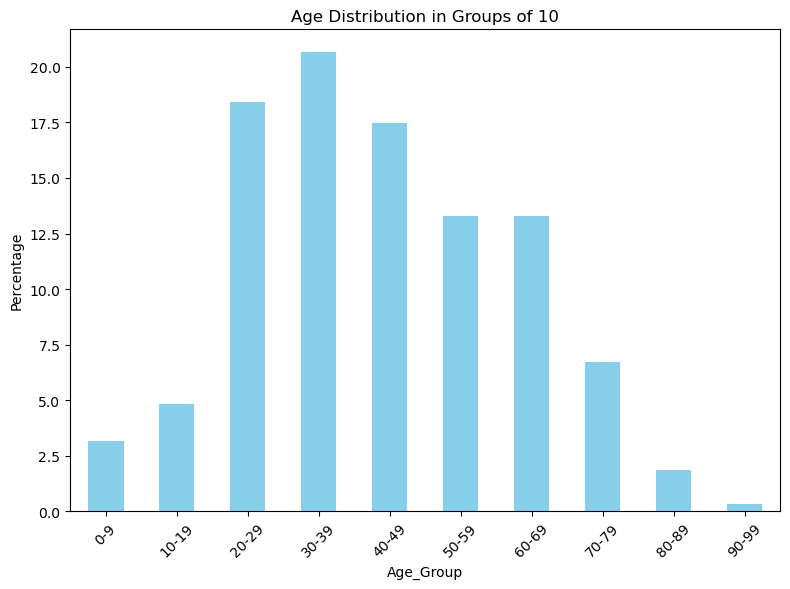

In [14]:
print(client_demographics.columns)

bin_plot_barchart(client_demographics, 'Age', 0, 100,10, 'Age_Group')


In [15]:
client_demographics.isna().any()

Client    False
Sex       False
Age       False
Tenure    False
dtype: bool

In [16]:
age_0 = np.where(client_demographics.Age == 0)
print(f"Number of rows where age is 0 {len(age_0[0])}" )
#display(client_demographics.loc[age_0_9])
client_demographics['Age_in_months'] = client_demographics.Age*12
age_less_than_tenure = np.where(client_demographics.Age_in_months < client_demographics.Tenure)[0]
print(f"Number of rows where age is less than tenure is {len(age_less_than_tenure)}" )
#display(client_demographics.loc[age_less_than_tenure])
age_0_tenure_more = set(age_less_than_tenure) & set(age_0[0])
elements_not_in_both = set(age_less_than_tenure) ^ set(age_0[0])
print(f"Number of rows where age is 0 to 9 and also less than tenure {len(age_0_tenure_more)}" )

# We see rows where the account tenure is more than the client's age. However under certain circumstances this is possible. 
# For example, when an account is inherit from a person's parents etc. Keeping the special circumstances, and with the 
# limited information available to us, I assume that these accounts are valid account. 
# Hence only removing the 1 row containing age=0

client_demographics.drop(index=age_0[0], inplace=True)
client_demographics.drop(columns=['Age_in_months'],inplace=True)

Number of rows where age is 0 1
Number of rows where age is less than tenure is 47
Number of rows where age is 0 to 9 and also less than tenure 1


Index(['Client', 'Sex', 'Age', 'Tenure'], dtype='object')


count    1611.000000
mean      101.377405
std        64.911600
min         0.000000
25%        44.000000
50%        97.000000
75%       151.000000
max       273.000000
Name: Tenure, dtype: float64

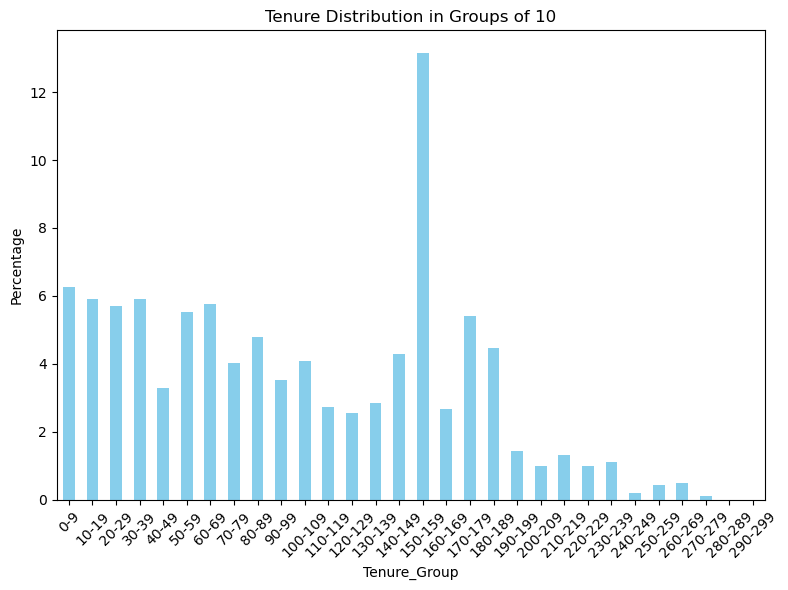

In [17]:
print(client_demographics.columns)
display(client_demographics.Tenure.describe())
bin_plot_barchart(client_demographics, 'Tenure', 0, 300,10, 'Tenure_Group')

# Analyzing client products

In [18]:
client_products.head()

,Client,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL
0,1,1,NaN,NaN,1.0,NaN,NaN,1333.802857,NaN,NaN,0.0,NaN,NaN
1,2,1,1.0,NaN,NaN,NaN,NaN,110.768571,13326.190357,NaN,NaN,NaN,NaN
2,3,1,NaN,1.0,NaN,NaN,NaN,482.654643,NaN,107.251786,NaN,NaN,NaN
3,4,1,1.0,NaN,NaN,1.0,NaN,1599.840714,76.437143,NaN,NaN,1110.381786,NaN
4,5,1,1.0,NaN,NaN,NaN,NaN,5353.483929,8079.715714,NaN,NaN,NaN,NaN


In [19]:
# Fill all NaN values with 0
client_products.fillna(0, inplace=True)

#Check if a client occurs once in the file
tmp = client_products.groupby(['Client']).Client.count()
print("Number of rows with more than 1 rows per client : ",sum(tmp>1))

Number of rows with more than 1 rows per client :  0


In [20]:
# Check if their are clients which don't have CA, SA or MF
tmp = client_products.Count_CA + client_products.Count_SA +client_products.Count_MF 
print(f" Clients with no CA, SA or MF : {np.where(tmp ==0.0)[0]}")

 Clients with no CA, SA or MF : []


In [21]:
# Checking if data contains rows where ActBal_CA is non zero even if Count_CA is 0
print(np.where([(client_products.Count_CA==0) & (client_products.ActBal_CA>0)]))
# Checking if data contains rows where ActBal_SA is non zero even if Count_SA is 0
print(np.where([(client_products.Count_SA==0) & (client_products.ActBal_SA>0)]))
# Checking if data contains rows where ActBal_MF is non zero even if Count_MF is 0
print(np.where([(client_products.Count_MF==0) & (client_products.ActBal_MF>0)]))
# Checking if data contains rows where ActBal_OVD is non zero even if Count_OVD is 0
print(np.where([(client_products.Count_OVD==0) & (client_products.ActBal_OVD>0)]))
# Checking if data contains rows where ActBal_CC is non zero even if Count_CC is 0
print(np.where([(client_products.Count_CC==0) & (client_products.ActBal_CC>0)]))
# Checking if data contains rows where ActBal_CL is non zero even if Count_CL is 0
print(np.where([(client_products.Count_CL==0) & (client_products.ActBal_CL>0)]))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


In [22]:
client_products.columns

Index(['Client', 'Count_CA', 'Count_SA', 'Count_MF', 'Count_OVD', 'Count_CC',
       'Count_CL', 'ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD',
       'ActBal_CC', 'ActBal_CL'],
      dtype='object')

In [23]:
columns = ['ActBal_CA', 'ActBal_SA', 'ActBal_MF', 'ActBal_OVD',
       'ActBal_CC', 'ActBal_CL']

for col in columns:
    print("######### col = ",col)
    desc = client_products[col].describe([0,0.25,0.5,0.75,0.85,0.9,0.95,0.99,1])
    display(desc)
    t_99 = desc['99%']
    t_95 = desc['95%']
    print(f"Values greater than 99 percentile : {np.where(client_products[col]>t_99)}")
    print(f"Values greater than 95 percentile : {np.where(client_products[col]>t_95)}")
#client_inflow_outflow.VolumeCred.describe([0,0.25,0.5,0.75,0.85,0.9,0.95,0.99,1])
#bin_plot_barchart(client_inflow_outflow, 'VolumeCred', 0, 100,10, 'Age_Group')

######### col =  ActBal_CA


count      1615.000000
mean       2438.601941
std        7072.777350
min           0.000000
0%            0.000000
25%          61.562143
50%         462.221786
75%        2174.864286
85%        3869.903500
90%        5783.797000
95%       10632.118250
99%       30533.916400
100%     171575.889643
max      171575.889643
Name: ActBal_CA, dtype: float64

Values greater than 99 percentile : (array([ 209,  229,  410,  454,  477,  632,  907,  999, 1102, 1128, 1150,
       1343, 1367, 1405, 1407, 1409, 1413], dtype=int64),)
Values greater than 95 percentile : (array([  18,   31,   32,   42,   81,  188,  205,  209,  214,  225,  229,
        323,  333,  344,  371,  410,  423,  445,  448,  454,  471,  477,
        632,  639,  648,  665,  673,  745,  752,  759,  763,  822,  871,
        901,  907,  968,  978,  999, 1041, 1068, 1092, 1102, 1119, 1128,
       1135, 1150, 1164, 1174, 1179, 1221, 1240, 1245, 1263, 1275, 1279,
       1281, 1289, 1302, 1311, 1323, 1324, 1332, 1341, 1343, 1346, 1353,
       1361, 1367, 1388, 1405, 1407, 1409, 1413, 1433, 1490, 1529, 1545,
       1568, 1570, 1587, 1606], dtype=int64),)
######### col =  ActBal_SA


count      1615.000000
mean       4009.812781
std       17909.061545
min           0.000000
0%            0.000000
25%           0.000000
50%           0.000000
75%           0.010000
85%        3586.747786
90%        7184.512929
95%       20632.692643
99%       87753.734429
100%     389883.830714
max      389883.830714
Name: ActBal_SA, dtype: float64

Values greater than 99 percentile : (array([  20,   82,  196,  218,  321,  351,  388,  534,  586,  600,  693,
        850,  885,  950,  962, 1277, 1329], dtype=int64),)
Values greater than 95 percentile : (array([  18,   20,   22,   44,   82,  103,  144,  150,  196,  205,  218,
        242,  301,  318,  321,  339,  343,  351,  353,  381,  384,  388,
        419,  452,  528,  534,  544,  565,  586,  591,  598,  600,  607,
        608,  633,  667,  693,  700,  720,  726,  733,  781,  796,  812,
        821,  850,  885,  894,  937,  941,  950,  962,  977,  989, 1029,
       1035, 1043, 1075, 1111, 1156, 1167, 1169, 1177, 1219, 1226, 1261,
       1277, 1329, 1361, 1366, 1385, 1395, 1402, 1409, 1412, 1418, 1486,
       1521, 1528, 1533, 1548], dtype=int64),)
######### col =  ActBal_MF


count      1615.000000
mean       3887.532659
std       34868.010169
min           0.000000
0%            0.000000
25%           0.000000
50%           0.000000
75%           0.000000
85%           0.000000
90%        1140.613643
95%       10443.760929
99%       65547.554443
100%     761235.504286
max      761235.504286
Name: ActBal_MF, dtype: float64

Values greater than 99 percentile : (array([  15,   52,  238,  275,  313,  323,  455,  542,  642,  677,  774,
        781,  927, 1040, 1117, 1199, 1328], dtype=int64),)
Values greater than 95 percentile : (array([  13,   15,   25,   47,   52,   72,   81,   95,  100,  117,  160,
        218,  238,  267,  275,  280,  306,  310,  313,  323,  352,  378,
        409,  455,  499,  524,  529,  542,  543,  546,  582,  599,  609,
        628,  642,  665,  677,  680,  683,  698,  726,  731,  739,  745,
        774,  775,  781,  786,  794,  801,  825,  845,  855,  881,  914,
        927, 1034, 1040, 1043, 1063, 1096, 1100, 1117, 1131, 1132, 1171,
       1187, 1191, 1199, 1225, 1234, 1241, 1290, 1323, 1328, 1410, 1424,
       1475, 1514, 1568, 1600], dtype=int64),)
######### col =  ActBal_OVD


count    1615.000000
mean       32.806506
std       157.926429
min         0.000000
0%          0.000000
25%         0.000000
50%         0.000000
75%         0.000000
85%         0.000000
90%         0.000000
95%       199.057000
99%       788.243321
100%     2055.325357
max      2055.325357
Name: ActBal_OVD, dtype: float64

Values greater than 99 percentile : (array([  40,  268,  336,  558,  746,  900, 1028, 1116, 1129, 1183, 1262,
       1294, 1377, 1463, 1466, 1518, 1575], dtype=int64),)
Values greater than 95 percentile : (array([   7,   22,   29,   40,   52,  126,  129,  165,  173,  210,  211,
        215,  224,  233,  268,  302,  336,  345,  416,  431,  463,  505,
        558,  562,  587,  596,  612,  656,  673,  712,  717,  720,  725,
        746,  755,  804,  812,  845,  891,  900,  915,  956,  963, 1000,
       1024, 1028, 1097, 1112, 1116, 1129, 1183, 1219, 1260, 1262, 1266,
       1289, 1294, 1314, 1319, 1331, 1363, 1377, 1383, 1384, 1415, 1418,
       1420, 1429, 1452, 1458, 1463, 1466, 1501, 1504, 1505, 1518, 1563,
       1575, 1581, 1593, 1609], dtype=int64),)
######### col =  ActBal_CC


count    1615.000000
mean       36.978465
std       190.869592
min       -15.479286
0%        -15.479286
25%         0.000000
50%         0.000000
75%         0.000000
85%         0.000000
90%         0.000000
95%       213.579893
99%       991.200450
100%     3522.233571
max      3522.233571
Name: ActBal_CC, dtype: float64

Values greater than 99 percentile : (array([   3,   17,  113,  213,  570,  601,  603,  762,  767,  795,  915,
       1021, 1067, 1097, 1428, 1493, 1509], dtype=int64),)
Values greater than 95 percentile : (array([   3,   17,   30,   33,   52,   65,   75,   99,  113,  138,  142,
        199,  201,  209,  213,  252,  300,  302,  335,  375,  391,  400,
        454,  478,  494,  560,  565,  567,  570,  601,  603,  606,  609,
        612,  647,  675,  696,  755,  762,  767,  779,  790,  793,  795,
        900,  909,  915,  923,  933,  948,  957,  985,  997, 1021, 1067,
       1097, 1147, 1181, 1190, 1206, 1229, 1255, 1286, 1294, 1361, 1368,
       1369, 1383, 1398, 1411, 1428, 1472, 1489, 1493, 1501, 1502, 1504,
       1509, 1510, 1572, 1579], dtype=int64),)
######### col =  ActBal_CL


count     1615.000000
mean       354.230135
std       1678.743095
min          0.000000
0%           0.000000
25%          0.000000
50%          0.000000
75%          0.000000
85%          0.000000
90%          0.000000
95%       2198.358179
99%       9692.436414
100%     20749.294643
max      20749.294643
Name: ActBal_CL, dtype: float64

Values greater than 99 percentile : (array([  13,   31,  112,  173,  174,  256,  341,  680,  913,  947, 1024,
       1097, 1115, 1116, 1236, 1386, 1498], dtype=int64),)
Values greater than 95 percentile : (array([  12,   13,   31,   53,   75,   94,  112,  133,  165,  173,  174,
        185,  188,  198,  256,  303,  324,  341,  347,  390,  393,  410,
        420,  486,  490,  493,  525,  565,  610,  650,  680,  695,  738,
        743,  749,  755,  762,  793,  795,  808,  818,  870,  900,  908,
        913,  933,  947, 1024, 1030, 1042, 1062, 1065, 1066, 1070, 1097,
       1102, 1113, 1115, 1116, 1133, 1159, 1215, 1236, 1258, 1262, 1266,
       1295, 1314, 1342, 1344, 1375, 1386, 1398, 1442, 1446, 1457, 1487,
       1498, 1579, 1607, 1611], dtype=int64),)


# client_inflow_outflow

In [24]:
client_inflow_outflow.head()

,Client,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
0,1017,0.005000,0.005000,1,1,118.046429,118.046429,25.000000,91.796429,0.000000,12,12,2,9,0
1,1456,364.772143,364.752857,4,3,774.980000,774.980000,14.285714,497.444286,258.607143,28,28,1,20,5
2,545,2471.719286,2471.719286,14,14,2190.257143,2190.257143,303.571429,179.082143,1229.428571,23,23,3,5,12
3,667,1127.792857,1127.792857,4,4,1344.603571,1344.603571,642.857143,194.285714,249.321429,21,21,3,4,8
4,1381,571.618214,571.618214,3,3,57.071429,57.071429,10.714286,46.357143,0.000000,6,6,1,5,0


In [25]:
client_inflow_outflow.describe()

,Client,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder
count,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000,1587.000000
mean,808.174543,1823.559572,1506.329113,5.541903,4.265280,1697.218658,1460.202903,257.937337,150.850401,715.974931,16.006931,13.596723,1.988658,5.240076,4.601134
std,466.744374,5864.792552,4661.535696,6.355383,4.944032,5183.787844,4281.369956,757.734230,311.938796,3215.106760,16.243554,12.975287,2.710704,8.386154,5.211451
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,405.500000,252.923393,214.290893,2.000000,2.000000,226.214286,211.848750,0.000000,0.000000,0.000000,4.000000,4.000000,0.000000,0.000000,0.000000
50%,808.000000,655.867500,620.858214,3.000000,3.000000,654.615357,632.148929,71.428571,20.139286,175.428571,11.000000,10.000000,1.000000,1.000000,3.000000
75%,1213.500000,1426.027143,1304.757143,6.000000,4.000000,1418.208214,1329.007857,353.370536,175.892500,507.607143,22.000000,19.000000,3.000000,7.000000,7.000000
max,1615.000000,107703.804286,98717.675000,63.000000,48.000000,119906.503929,73477.932500,23571.428571,3637.616786,72278.782143,102.000000,83.000000,25.000000,60.000000,34.000000


In [26]:
def sanity_check(col_volume, col_transactions):
    errors = np.where((client_inflow_outflow[col_transactions]==0) & (client_inflow_outflow[col_volume] >0))[0] + np.where((client_inflow_outflow[col_transactions]>0) & (client_inflow_outflow[col_volume] ==0))[0]
    return(errors)    

In [27]:
client_inflow_outflow.columns

Index(['Client', 'VolumeCred', 'VolumeCred_CA', 'TransactionsCred',
       'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder'],
      dtype='object')

In [28]:
vol_cols = ['VolumeCred_CA', 'VolumeDeb', 'VolumeDeb_CA','VolumeDebCash_Card', 'VolumeDebCashless_Card','VolumeDeb_PaymentOrder']
trans_cols = ['TransactionsCred_CA', 'TransactionsDeb', 'TransactionsDeb_CA','TransactionsDebCash_Card', 'TransactionsDebCashless_Card','TransactionsDeb_PaymentOrder']

for vol, trans in zip(vol_cols,trans_cols):
    print(f"Sanity check for {vol} and {trans} : {sanity_check(vol, trans)}")
    
    

Sanity check for VolumeCred_CA and TransactionsCred_CA : []
Sanity check for VolumeDeb and TransactionsDeb : []
Sanity check for VolumeDeb_CA and TransactionsDeb_CA : []
Sanity check for VolumeDebCash_Card and TransactionsDebCash_Card : []
Sanity check for VolumeDebCashless_Card and TransactionsDebCashless_Card : []
Sanity check for VolumeDeb_PaymentOrder and TransactionsDeb_PaymentOrder : []


In [29]:
columns = ['VolumeCred', 'VolumeCred_CA', 'TransactionsCred',
       'TransactionsCred_CA', 'VolumeDeb', 'VolumeDeb_CA',
       'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder']

for col in columns:
    print("######### col = ",col)
    desc = client_inflow_outflow[col].describe([0,0.25,0.5,0.75,0.85,0.9,0.95,0.99,1])
    display(desc)
    t_99 = desc['99%']
    t_95 = desc['95%']
    print(f"Values greater than 99 percentile : {np.where(client_inflow_outflow[col]>t_99)}")
    print(f"Values greater than 95 percentile : {np.where(client_inflow_outflow[col]>t_95)}")
#client_inflow_outflow.VolumeCred.describe([0,0.25,0.5,0.75,0.85,0.9,0.95,0.99,1])
#bin_plot_barchart(client_inflow_outflow, 'VolumeCred', 0, 100,10, 'Age_Group')

######### col =  VolumeCred


count      1587.000000
mean       1823.559572
std        5864.792552
min           0.000000
0%            0.000000
25%         252.923393
50%         655.867500
75%        1426.027143
85%        2173.207250
90%        3221.782214
95%        6020.479429
99%       20792.869214
100%     107703.804286
max      107703.804286
Name: VolumeCred, dtype: float64

Values greater than 99 percentile : (array([  65,  112,  157,  621,  636,  746,  766,  768,  972, 1066, 1130,
       1184, 1382, 1413, 1443, 1550], dtype=int64),)
Values greater than 95 percentile : (array([  65,  112,  157,  162,  192,  204,  300,  336,  348,  403,  412,
        413,  466,  477,  493,  506,  531,  568,  592,  603,  619,  621,
        636,  650,  682,  729,  742,  746,  753,  765,  766,  768,  770,
        788,  790,  857,  870,  873,  890,  893,  898,  916,  951,  972,
       1011, 1038, 1049, 1056, 1066, 1070, 1078, 1086, 1127, 1130, 1138,
       1145, 1159, 1184, 1198, 1202, 1234, 1255, 1256, 1258, 1272, 1323,
       1343, 1382, 1387, 1393, 1413, 1443, 1454, 1475, 1489, 1496, 1524,
       1529, 1550, 1572], dtype=int64),)
######### col =  VolumeCred_CA


count     1587.000000
mean      1506.329113
std       4661.535696
min          0.000000
0%           0.000000
25%        214.290893
50%        620.858214
75%       1304.757143
85%       1901.816500
90%       2502.676643
95%       4652.542536
99%      18215.890007
100%     98717.675000
max      98717.675000
Name: VolumeCred_CA, dtype: float64

Values greater than 99 percentile : (array([  65,  112,  619,  621,  636,  746,  753,  766,  768, 1066, 1127,
       1159, 1184, 1258, 1382, 1443], dtype=int64),)
Values greater than 95 percentile : (array([  65,  112,  162,  192,  204,  300,  313,  336,  348,  349,  451,
        466,  477,  493,  506,  515,  568,  592,  603,  619,  621,  636,
        670,  682,  729,  742,  746,  753,  766,  768,  770,  788,  790,
        857,  870,  873,  893,  898,  916,  951,  969,  972, 1038, 1041,
       1056, 1066, 1070, 1078, 1101, 1127, 1130, 1138, 1145, 1159, 1184,
       1198, 1202, 1234, 1255, 1256, 1258, 1272, 1323, 1343, 1346, 1347,
       1382, 1387, 1393, 1413, 1417, 1419, 1443, 1454, 1475, 1496, 1524,
       1529, 1550, 1572], dtype=int64),)
######### col =  TransactionsCred


count    1587.000000
mean        5.541903
std         6.355383
min         0.000000
0%          0.000000
25%         2.000000
50%         3.000000
75%         6.000000
85%         9.000000
90%        12.000000
95%        19.000000
99%        31.140000
100%       63.000000
max        63.000000
Name: TransactionsCred, dtype: float64

Values greater than 99 percentile : (array([  25,   65,  102,  217,  245,  292,  387,  412,  413,  747,  789,
       1009, 1011, 1166, 1198, 1256], dtype=int64),)
Values greater than 95 percentile : (array([  23,   25,   39,   58,   65,  102,  110,  119,  163,  165,  182,
        184,  192,  204,  217,  245,  292,  309,  312,  350,  351,  371,
        387,  399,  412,  413,  477,  484,  512,  549,  552,  577,  637,
        664,  666,  681,  687,  708,  745,  747,  760,  769,  779,  784,
        789,  813,  889,  894,  996, 1009, 1011, 1016, 1049, 1078, 1102,
       1161, 1166, 1195, 1197, 1198, 1205, 1215, 1219, 1225, 1240, 1241,
       1243, 1256, 1298, 1309, 1334, 1382, 1402, 1436, 1488, 1489, 1522],
      dtype=int64),)
######### col =  TransactionsCred_CA


count    1587.000000
mean        4.265280
std         4.944032
min         0.000000
0%          0.000000
25%         2.000000
50%         3.000000
75%         4.000000
85%         6.000000
90%         8.000000
95%        14.000000
99%        27.140000
100%       48.000000
max        48.000000
Name: TransactionsCred_CA, dtype: float64

Values greater than 99 percentile : (array([  25,   65,  102,  192,  217,  245,  387,  413,  687,  747,  789,
        889, 1009, 1011, 1166, 1198], dtype=int64),)
Values greater than 95 percentile : (array([  23,   25,   39,   58,   65,  102,  110,  119,  163,  182,  184,
        192,  217,  245,  292,  312,  350,  358,  371,  387,  412,  413,
        477,  512,  549,  552,  577,  637,  666,  687,  708,  745,  747,
        754,  760,  769,  779,  784,  789,  813,  889,  894,  996, 1009,
       1011, 1016, 1049, 1078, 1102, 1106, 1161, 1166, 1197, 1198, 1205,
       1215, 1219, 1225, 1241, 1256, 1298, 1299, 1309, 1334, 1382, 1402,
       1436, 1483, 1488, 1522, 1564, 1579], dtype=int64),)
######### col =  VolumeDeb


count      1587.000000
mean       1697.218658
std        5183.787844
min           0.000000
0%            0.000000
25%         226.214286
50%         654.615357
75%        1418.208214
85%        2208.215679
90%        3047.306143
95%        5683.105357
99%       20281.948071
100%     119906.503929
max      119906.503929
Name: VolumeDeb, dtype: float64

Values greater than 99 percentile : (array([  65,  157,  192,  329,  636,  746,  766,  768,  857,  928,  972,
       1066, 1159, 1184, 1443, 1550], dtype=int64),)
Values greater than 95 percentile : (array([  62,   65,   97,  102,  112,  157,  162,  192,  204,  208,  237,
        300,  313,  329,  336,  348,  390,  403,  412,  413,  447,  466,
        501,  506,  531,  568,  592,  619,  636,  650,  664,  682,  729,
        742,  746,  753,  766,  768,  770,  776,  788,  824,  857,  890,
        893,  898,  928,  951,  972, 1011, 1049, 1066, 1070, 1078, 1101,
       1127, 1130, 1159, 1184, 1198, 1202, 1211, 1234, 1256, 1258, 1323,
       1346, 1387, 1413, 1419, 1443, 1486, 1489, 1496, 1514, 1520, 1524,
       1529, 1550, 1572], dtype=int64),)
######### col =  VolumeDeb_CA


count     1587.000000
mean      1460.202903
std       4281.369956
min          0.000000
0%           0.000000
25%        211.848750
50%        632.148929
75%       1329.007857
85%       1919.815000
90%       2455.894214
95%       4230.807929
99%      16305.906464
100%     73477.932500
max      73477.932500
Name: VolumeDeb_CA, dtype: float64

Values greater than 99 percentile : (array([  65,  157,  192,  329,  636,  746,  766,  768, 1066, 1078, 1127,
       1159, 1184, 1258, 1443, 1550], dtype=int64),)
Values greater than 95 percentile : (array([  62,   65,   97,  102,  112,  157,  162,  192,  204,  208,  237,
        300,  313,  314,  315,  329,  340,  348,  352,  390,  403,  447,
        466,  501,  506,  515,  531,  568,  592,  619,  636,  670,  682,
        729,  742,  746,  753,  766,  768,  776,  788,  824,  828,  857,
        892,  893,  898,  951,  972, 1066, 1070, 1078, 1101, 1127, 1130,
       1141, 1145, 1159, 1184, 1198, 1202, 1234, 1256, 1258, 1268, 1323,
       1346, 1382, 1387, 1419, 1443, 1486, 1489, 1496, 1514, 1520, 1524,
       1529, 1550, 1572], dtype=int64),)
######### col =  VolumeDebCash_Card


count     1587.000000
mean       257.937337
std        757.734230
min          0.000000
0%           0.000000
25%          0.000000
50%         71.428571
75%        353.370536
85%        521.428571
90%        642.857143
95%        864.642857
99%       1790.714286
100%     23571.428571
max      23571.428571
Name: VolumeDebCash_Card, dtype: float64

Values greater than 99 percentile : (array([  62,   97,  192,  229,  501,  568,  584,  850,  972, 1037, 1066,
       1070, 1202, 1475, 1533, 1556], dtype=int64),)
Values greater than 95 percentile : (array([  25,   62,   65,   97,  102,  137,  162,  184,  192,  197,  200,
        219,  229,  248,  258,  300,  303,  309,  314,  341,  348,  415,
        416,  451,  475,  490,  501,  568,  584,  592,  670,  673,  732,
        739,  753,  754,  768,  776,  824,  829,  838,  850,  906,  951,
        971,  972, 1014, 1037, 1049, 1066, 1070, 1076, 1125, 1141, 1199,
       1201, 1202, 1216, 1268, 1276, 1310, 1312, 1333, 1340, 1360, 1379,
       1391, 1419, 1431, 1446, 1455, 1475, 1495, 1510, 1529, 1533, 1543,
       1556, 1558, 1570], dtype=int64),)
######### col =  VolumeDebCashless_Card


count    1587.000000
mean      150.850401
std       311.938796
min         0.000000
0%          0.000000
25%         0.000000
50%        20.139286
75%       175.892500
85%       311.116929
90%       429.915929
95%       672.805571
99%      1385.365357
100%     3637.616786
max      3637.616786
Name: VolumeDebCashless_Card, dtype: float64

Values greater than 99 percentile : (array([  41,   62,   97,  162,  192,  233,  300,  348,  406,  913, 1078,
       1141, 1159, 1198, 1496, 1547], dtype=int64),)
Values greater than 95 percentile : (array([  41,   50,   62,   72,   95,   97,  102,  162,  192,  198,  233,
        237,  282,  300,  329,  348,  387,  390,  399,  406,  443,  451,
        478,  557,  605,  664,  702,  747,  767,  772,  801,  824,  839,
        842,  887,  913,  968, 1049, 1062, 1078, 1096, 1127, 1130, 1141,
       1155, 1159, 1161, 1167, 1198, 1234, 1251, 1268, 1283, 1292, 1311,
       1376, 1383, 1387, 1391, 1409, 1412, 1416, 1417, 1418, 1419, 1421,
       1427, 1465, 1478, 1489, 1492, 1493, 1496, 1498, 1504, 1529, 1547,
       1572, 1575, 1578], dtype=int64),)
######### col =  VolumeDeb_PaymentOrder


count     1587.000000
mean       715.974931
std       3215.106760
min          0.000000
0%           0.000000
25%          0.000000
50%        175.428571
75%        507.607143
85%        826.037286
90%       1123.592857
95%       2184.289286
99%      12470.028650
100%     72278.782143
max      72278.782143
Name: VolumeDeb_PaymentOrder, dtype: float64

Values greater than 99 percentile : (array([ 112,  157,  192,  204,  329,  636,  766,  768, 1066, 1078, 1127,
       1159, 1234, 1258, 1323, 1550], dtype=int64),)
Values greater than 95 percentile : (array([  26,   65,   73,  112,  153,  157,  162,  192,  204,  236,  300,
        308,  313,  314,  315,  329,  336,  340,  348,  403,  447,  466,
        475,  506,  507,  515,  531,  636,  670,  682,  729,  753,  756,
        766,  768,  776,  782,  824,  828,  837,  857,  873,  893,  898,
        916,  949, 1066, 1070, 1074, 1078, 1088, 1101, 1127, 1129, 1145,
       1159, 1184, 1202, 1211, 1234, 1237, 1248, 1255, 1256, 1258, 1268,
       1323, 1346, 1349, 1382, 1387, 1419, 1443, 1446, 1461, 1520, 1529,
       1550, 1568, 1572], dtype=int64),)
######### col =  TransactionsDeb


count    1587.000000
mean       16.006931
std        16.243554
min         0.000000
0%          0.000000
25%         4.000000
50%        11.000000
75%        22.000000
85%        31.100000
90%        38.000000
95%        48.700000
99%        75.140000
100%      102.000000
max       102.000000
Name: TransactionsDeb, dtype: float64

Values greater than 99 percentile : (array([  25,   84,  102,  192,  245,  283,  387,  413,  747, 1011, 1049,
       1161, 1166, 1198, 1234, 1487], dtype=int64),)
Values greater than 95 percentile : (array([  23,   25,   28,   35,   72,   84,  102,  163,  192,  217,  233,
        245,  283,  292,  300,  309,  348,  387,  399,  406,  412,  413,
        524,  526,  549,  563,  636,  637,  687,  742,  745,  747,  769,
        772,  779,  784,  788,  789,  792,  813,  824,  936,  981,  993,
       1009, 1011, 1016, 1049, 1066, 1070, 1078, 1127, 1155, 1159, 1161,
       1166, 1196, 1198, 1219, 1226, 1234, 1241, 1243, 1251, 1256, 1268,
       1273, 1298, 1376, 1387, 1391, 1402, 1418, 1419, 1429, 1436, 1478,
       1487, 1496, 1529], dtype=int64),)
######### col =  TransactionsDeb_CA


count    1587.000000
mean       13.596723
std        12.975287
min         0.000000
0%          0.000000
25%         4.000000
50%        10.000000
75%        19.000000
85%        25.000000
90%        31.000000
95%        39.000000
99%        61.280000
100%       83.000000
max        83.000000
Name: TransactionsDeb_CA, dtype: float64

Values greater than 99 percentile : (array([  25,   84,  192,  233,  245,  283,  300,  747,  936, 1066, 1070,
       1155, 1159, 1196, 1268, 1478], dtype=int64),)
Values greater than 95 percentile : (array([  25,   28,   35,   62,   65,   84,  102,  192,  219,  233,  245,
        281,  283,  300,  309,  387,  406,  413,  458,  519,  526,  563,
        636,  664,  687,  732,  747,  772,  779,  792,  824,  936,  981,
        993, 1005, 1009, 1016, 1062, 1066, 1070, 1071, 1078, 1127, 1141,
       1155, 1159, 1161, 1166, 1187, 1196, 1198, 1226, 1243, 1251, 1268,
       1273, 1283, 1285, 1360, 1376, 1387, 1391, 1402, 1409, 1412, 1418,
       1427, 1429, 1465, 1478, 1493, 1508, 1513], dtype=int64),)
######### col =  TransactionsDebCash_Card


count    1587.000000
mean        1.988658
std         2.710704
min         0.000000
0%          0.000000
25%         0.000000
50%         1.000000
75%         3.000000
85%         4.000000
90%         6.000000
95%         7.000000
99%        12.000000
100%       25.000000
max        25.000000
Name: TransactionsDebCash_Card, dtype: float64

Values greater than 99 percentile : (array([  32,   84,  170,  214,  219,  283,  807,  838, 1070, 1097, 1556],
      dtype=int64),)
Values greater than 95 percentile : (array([  28,   29,   32,   62,   67,   84,   92,  115,  118,  142,  149,
        170,  214,  219,  245,  281,  283,  300,  309,  348,  446,  501,
        563,  564,  575,  632,  641,  732,  747,  759,  772,  807,  824,
        838,  868,  877,  901,  931,  938,  946,  979,  981,  993, 1001,
       1009, 1066, 1069, 1070, 1097, 1098, 1155, 1166, 1193, 1196, 1212,
       1226, 1252, 1268, 1273, 1310, 1360, 1376, 1436, 1437, 1508, 1522,
       1556, 1558], dtype=int64),)
######### col =  TransactionsDebCashless_Card


count    1587.000000
mean        5.240076
std         8.386154
min         0.000000
0%          0.000000
25%         0.000000
50%         1.000000
75%         7.000000
85%        12.000000
90%        16.000000
95%        24.000000
99%        37.140000
100%       60.000000
max        60.000000
Name: TransactionsDebCashless_Card, dtype: float64

Values greater than 99 percentile : (array([  35,   41,  192,  233,  387,  406,  747,  936, 1234, 1251, 1376,
       1387, 1418, 1465, 1487, 1496], dtype=int64),)
Values greater than 95 percentile : (array([  25,   28,   35,   41,   72,   78,   84,  192,  233,  245,  263,
        281,  298,  300,  321,  349,  387,  406,  519,  524,  557,  619,
        677,  693,  719,  747,  772,  784,  792,  813,  842,  913,  932,
        936,  993, 1011, 1016, 1049, 1071, 1096, 1114, 1127, 1141, 1155,
       1159, 1161, 1185, 1190, 1196, 1198, 1200, 1201, 1226, 1234, 1251,
       1273, 1283, 1285, 1376, 1387, 1391, 1402, 1408, 1409, 1416, 1418,
       1419, 1427, 1459, 1465, 1472, 1478, 1487, 1493, 1496, 1529, 1563,
       1575], dtype=int64),)
######### col =  TransactionsDeb_PaymentOrder


count    1587.000000
mean        4.601134
std         5.211451
min         0.000000
0%          0.000000
25%         0.000000
50%         3.000000
75%         7.000000
85%        10.000000
90%        12.000000
95%        15.000000
99%        21.000000
100%       34.000000
max        34.000000
Name: TransactionsDeb_PaymentOrder, dtype: float64

Values greater than 99 percentile : (array([ 196,  348,  413,  506,  554,  729,  824, 1011, 1031, 1066, 1078,
       1159, 1268, 1478, 1564], dtype=int64),)
Values greater than 95 percentile : (array([  25,   65,   84,  169,  196,  217,  245,  314,  315,  336,  348,
        358,  413,  422,  506,  521,  526,  554,  563,  582,  636,  679,
        682,  729,  732,  742,  747,  766,  768,  772,  785,  824,  865,
        873,  893,  918,  935, 1011, 1031, 1060, 1066, 1078, 1096, 1118,
       1145, 1159, 1161, 1166, 1187, 1196, 1202, 1243, 1247, 1256, 1263,
       1268, 1323, 1346, 1369, 1387, 1419, 1443, 1473, 1478, 1548, 1564,
       1570], dtype=int64),)


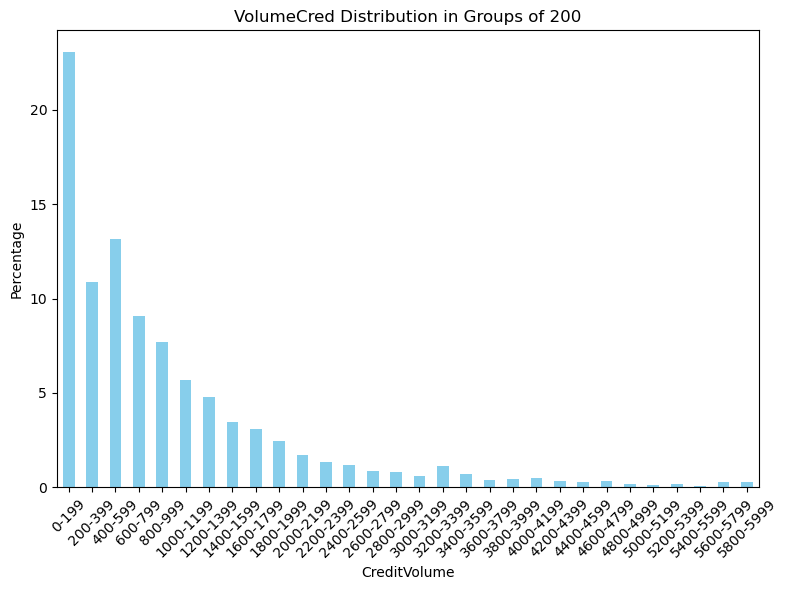

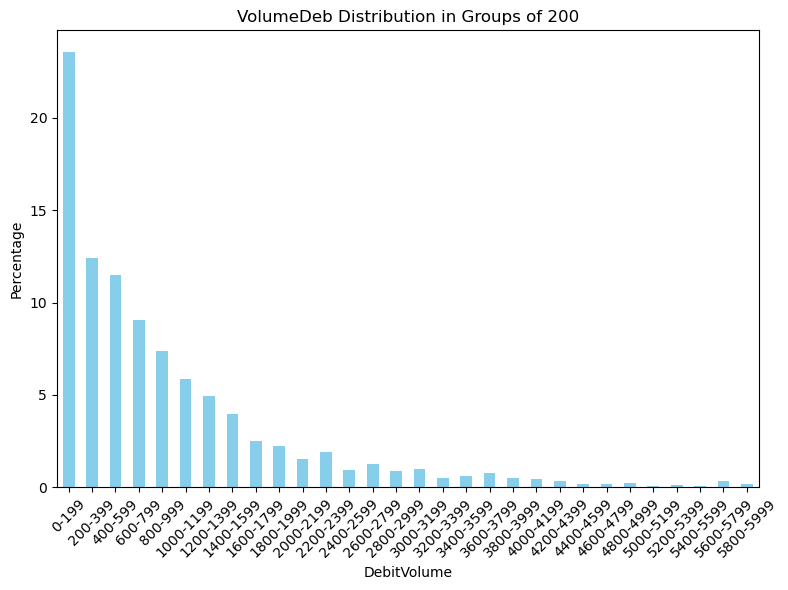

In [30]:
#bin_plot_barchart(client_inflow_outflow, 'VolumeCred', 0, 107703,200, 'CreditVolume')
bin_plot_barchart(client_inflow_outflow, 'VolumeCred', 0, 6000,200, 'CreditVolume')
bin_plot_barchart(client_inflow_outflow, 'VolumeDeb', 0, 6000,200, 'DebitVolume')
## Looking at these graphs, we can see that most of the data is less than 6000, so removing others as outliers

In [31]:
def plot_scatter(df,col1, col2):
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=df,x=col1, y=col2,s=100)
    plt.title("scatter plot")
    plt.show()

In [32]:
'''col1s = ['Debit_percent_amount_Cash_Card','Debit_percent_amount_Cashless_Card','Debit_percent_amount_Payment_order']
col2s = ['Debit_percent_transactions_Cash_Card','Debit_percent_transactions_Cashless_Card','Debit_percent_transactions_Payment_order']

for c1, c2 in zip(col1s, col2s):
    plot_scatter(client_inflow_outflow, c1,c2)
'''

"col1s = ['Debit_percent_amount_Cash_Card','Debit_percent_amount_Cashless_Card','Debit_percent_amount_Payment_order']\ncol2s = ['Debit_percent_transactions_Cash_Card','Debit_percent_transactions_Cashless_Card','Debit_percent_transactions_Payment_order']\n\nfor c1, c2 in zip(col1s, col2s):\n    plot_scatter(client_inflow_outflow, c1,c2)\n"

From above plots we see that generally if % of amount increases, % of transactions also increases.
Exception are some clients for Payment order where the number of transactions remain same but larger transactions are made. 
Keeping this in mind, we can just use the Amount % as a feature for now to classify clients.

# Analyzing client_sales_rev

In [33]:
display(client_sales_rev.head())
client_sales_rev.shape

,Client,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1094,0,1,0,0.000000,5.138571,0.0000
1,1484,1,0,1,25.609107,0.000000,8.7225
2,20,0,1,0,0.000000,3.822500,0.0000
3,1193,0,0,0,0.000000,0.000000,0.0000
4,142,0,0,0,0.000000,0.000000,0.0000


(969, 7)

In [34]:
print(f"Number of cilents with no sale data : {sum(client_sales_rev.Sale_MF + client_sales_rev.Sale_CC + client_sales_rev.Sale_CL ==0)}")
print(f"Number of cilents with only 1 sale : {sum(client_sales_rev.Sale_MF + client_sales_rev.Sale_CC + client_sales_rev.Sale_CL ==1)}")
print(f"Number of cilents with 2 sales : {sum(client_sales_rev.Sale_MF + client_sales_rev.Sale_CC + client_sales_rev.Sale_CL ==2)}")
print(f"Number of cilents with 3 sales : {sum(client_sales_rev.Sale_MF + client_sales_rev.Sale_CC + client_sales_rev.Sale_CL ==3)}")


Number of cilents with no sale data : 400
Number of cilents with only 1 sale : 427
Number of cilents with 2 sales : 128
Number of cilents with 3 sales : 14


# Combining all data frames

In [35]:
dfs = [client_demographics,client_products,client_inflow_outflow,client_sales_rev]

In [36]:
data = reduce(lambda df1, df2 : pd.merge(df1,df2, on='Client', how='inner'), dfs)

In [37]:
data.head()

,Client,Sex,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
0,1217,M,38,165,1,0.0,0.0,0.0,0.0,0.0,6752.244643,0.000000,0.0,0.0000,0.00,0.000000,0.002143,0.002143,1,1,714.285714,714.285714,0.000000,0.000000,714.285714,1,1,0,0,1,0,0,0,0.000000,0.000000,0.000000
1,850,F,49,44,1,0.0,0.0,0.0,0.0,0.0,43.523214,0.000000,0.0,0.0000,0.00,0.000000,1392.402857,1392.402857,3,3,1226.345357,1226.345357,0.000000,0.000000,121.928571,6,6,0,0,1,0,1,0,0.000000,0.893929,0.000000
2,1473,M,54,34,1,1.0,0.0,0.0,1.0,1.0,29.024286,14447.801429,0.0,0.0000,653.91,1132.590357,1787.127500,939.128929,14,5,3875.137857,3794.580714,357.142857,444.597500,2076.785714,48,38,1,26,11,1,0,0,4.929643,0.000000,0.000000
3,1038,M,29,106,1,0.0,0.0,0.0,0.0,0.0,27.035714,0.000000,0.0,0.0000,0.00,0.000000,0.006071,0.006071,1,1,0.000000,0.000000,0.000000,0.000000,0.000000,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
4,225,M,14,187,1,0.0,0.0,1.0,0.0,0.0,345.686071,0.000000,0.0,618.3975,0.00,0.000000,0.007500,0.007500,1,1,130.521429,130.521429,0.000000,111.235714,19.285714,5,5,0,4,1,0,0,1,0.000000,0.000000,8.130714


In [38]:
data.isna().any()

Client                          False
Sex                             False
Age                             False
Tenure                          False
Count_CA                        False
Count_SA                        False
Count_MF                        False
Count_OVD                       False
Count_CC                        False
Count_CL                        False
ActBal_CA                       False
ActBal_SA                       False
ActBal_MF                       False
ActBal_OVD                      False
ActBal_CC                       False
ActBal_CL                       False
VolumeCred                      False
VolumeCred_CA                   False
TransactionsCred                False
TransactionsCred_CA             False
VolumeDeb                       False
VolumeDeb_CA                    False
VolumeDebCash_Card              False
VolumeDebCashless_Card          False
VolumeDeb_PaymentOrder          False
TransactionsDeb                 False
Transactions

In [39]:
indices = set(np.where(data.VolumeCred < 6000)[0]) & set(np.where(data.VolumeDeb < 6000)[0] )
indices = indices & set(np.where(data.ActBal_CA < 10000)[0])
indices = indices & set(np.where(data.ActBal_SA < 10000)[0])
indices = indices & set(np.where(data.ActBal_MF < 10000)[0])
#indices = indices & set(np.where(data.ActBal_CL < 10000)[0])
#indices = indices & set(np.where(data.ActBal_CC < 1000)[0])
print(len(indices))
data_outlier_rem = data.iloc[list(indices),]

736


In [40]:
print(data_outlier_rem.shape)
data_outlier_rem.head()
data_outlier_rem.describe()

(736, 36)


,Client,Age,Tenure,Count_CA,Count_SA,Count_MF,Count_OVD,Count_CC,Count_CL,ActBal_CA,ActBal_SA,ActBal_MF,ActBal_OVD,ActBal_CC,ActBal_CL,VolumeCred,VolumeCred_CA,TransactionsCred,TransactionsCred_CA,VolumeDeb,VolumeDeb_CA,VolumeDebCash_Card,VolumeDebCashless_Card,VolumeDeb_PaymentOrder,TransactionsDeb,TransactionsDeb_CA,TransactionsDebCash_Card,TransactionsDebCashless_Card,TransactionsDeb_PaymentOrder,Sale_MF,Sale_CC,Sale_CL,Revenue_MF,Revenue_CC,Revenue_CL
count,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.000000,736.00000,736.000000,736.000000,736.000000,736.000000
mean,819.199728,42.997283,99.686141,1.070652,0.220109,0.610054,0.267663,0.110054,0.093750,1295.437777,515.665915,237.081740,44.134293,32.170374,337.759881,903.959908,812.276277,5.194293,4.047554,911.662309,815.300632,214.868742,123.392193,337.050066,15.031250,12.846467,1.987772,4.771739,4.139946,0.199728,0.21875,0.293478,1.689595,2.759137,3.386683
std,466.553208,18.351148,65.084231,0.300399,0.500805,3.723630,0.443042,0.313170,0.318438,1881.728683,1607.668206,1158.207071,194.170898,161.755186,1520.559690,996.378276,869.201186,5.557518,4.286244,995.407105,850.236635,320.619098,212.612753,529.799861,14.354514,11.635721,2.676908,7.336393,4.598519,0.400068,0.41368,0.455665,6.600352,19.812291,6.560099
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-15.479286,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,421.750000,29.000000,43.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,72.952321,0.000000,0.000000,0.000000,0.000000,0.000000,212.147232,196.441696,2.000000,2.000000,202.868929,188.879464,0.000000,0.000000,0.000000,4.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,822.500000,41.000000,93.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,461.978929,0.000000,0.000000,0.000000,0.000000,0.000000,620.089821,572.895714,3.000000,3.000000,626.870714,588.928214,71.428571,23.606607,154.437500,11.500000,10.000000,1.000000,1.000000,3.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
75%,1221.500000,57.000000,151.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1746.064107,0.000000,0.000000,0.000000,0.000000,0.000000,1234.478839,1142.673214,6.000000,4.000000,1260.244107,1159.651429,321.428571,168.537768,433.258036,21.000000,18.000000,3.000000,7.000000,6.000000,0.000000,0.00000,1.000000,0.000000,0.000000,4.223214
max,1615.000000,88.000000,267.000000,3.000000,3.000000,79.000000,1.000000,1.000000,2.000000,9830.705357,9686.631071,9824.236786,2055.325357,1767.785357,17300.489643,5998.368929,5823.408929,40.000000,33.000000,5647.542857,5244.964286,2250.000000,1889.976429,4232.285714,102.000000,79.000000,25.000000,47.000000,24.000000,1.000000,1.00000,1.000000,65.704107,407.962500,46.392857


In [41]:
data_outlier_rem.columns

Index(['Client', 'Sex', 'Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder', 'Sale_MF', 'Sale_CC', 'Sale_CL',
       'Revenue_MF', 'Revenue_CC', 'Revenue_CL'],
      dtype='object')

In [42]:
#data.to_pickle('data_for_modeling.pkl')
#data_outlier_rem.to_pickle('data_for_modeling.pkl')

# Correlation Analysis

In [43]:
scaler = StandardScaler()
cols_to_standardize = ['Age', 'Tenure', 'Count_CA', 'Count_SA', 'Count_MF',
       'Count_OVD', 'Count_CC', 'Count_CL', 'ActBal_CA', 'ActBal_SA',
       'ActBal_MF', 'ActBal_OVD', 'ActBal_CC', 'ActBal_CL', 'VolumeCred',
       'VolumeCred_CA', 'TransactionsCred', 'TransactionsCred_CA', 'VolumeDeb',
       'VolumeDeb_CA', 'VolumeDebCash_Card', 'VolumeDebCashless_Card',
       'VolumeDeb_PaymentOrder', 'TransactionsDeb', 'TransactionsDeb_CA',
       'TransactionsDebCash_Card', 'TransactionsDebCashless_Card',
       'TransactionsDeb_PaymentOrder']
data_outlier_rem[cols_to_standardize] = scaler.fit_transform(data_outlier_rem[cols_to_standardize])

C:\Users\vivek.choudhary\AppData\Local\Temp\ipykernel_2424\1778348002.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_outlier_rem[cols_to_standardize] = scaler.fit_transform(data_outlier_rem[cols_to_standardize])


In [44]:
correlation_matrix = data_outlier_rem[cols_to_standardize].corr()

In [45]:
correlated_features = []
for col in correlation_matrix.columns:
    rows = np.where((correlation_matrix[col] > 0.85) &(correlation_matrix[col] < 1))
    if len(rows[0]) > 0 :
        tmp = [(col,correlation_matrix.index[r],correlation_matrix[col][r]) for r in rows[0]] 
        correlated_features.append(tmp)
print(correlated_features)

[[('VolumeCred', 'VolumeCred_CA', 0.9643096599507676)], [('VolumeCred_CA', 'VolumeCred', 0.9643096599507676)], [('TransactionsCred', 'TransactionsCred_CA', 0.9437899408491135)], [('TransactionsCred_CA', 'TransactionsCred', 0.9437899408491135)], [('VolumeDeb', 'VolumeDeb_CA', 0.9508575892846056)], [('VolumeDeb_CA', 'VolumeDeb', 0.9508575892846056)], [('TransactionsDeb', 'TransactionsDeb_CA', 0.9233653572569113)], [('TransactionsDeb_CA', 'TransactionsDeb', 0.9233653572569113)]]


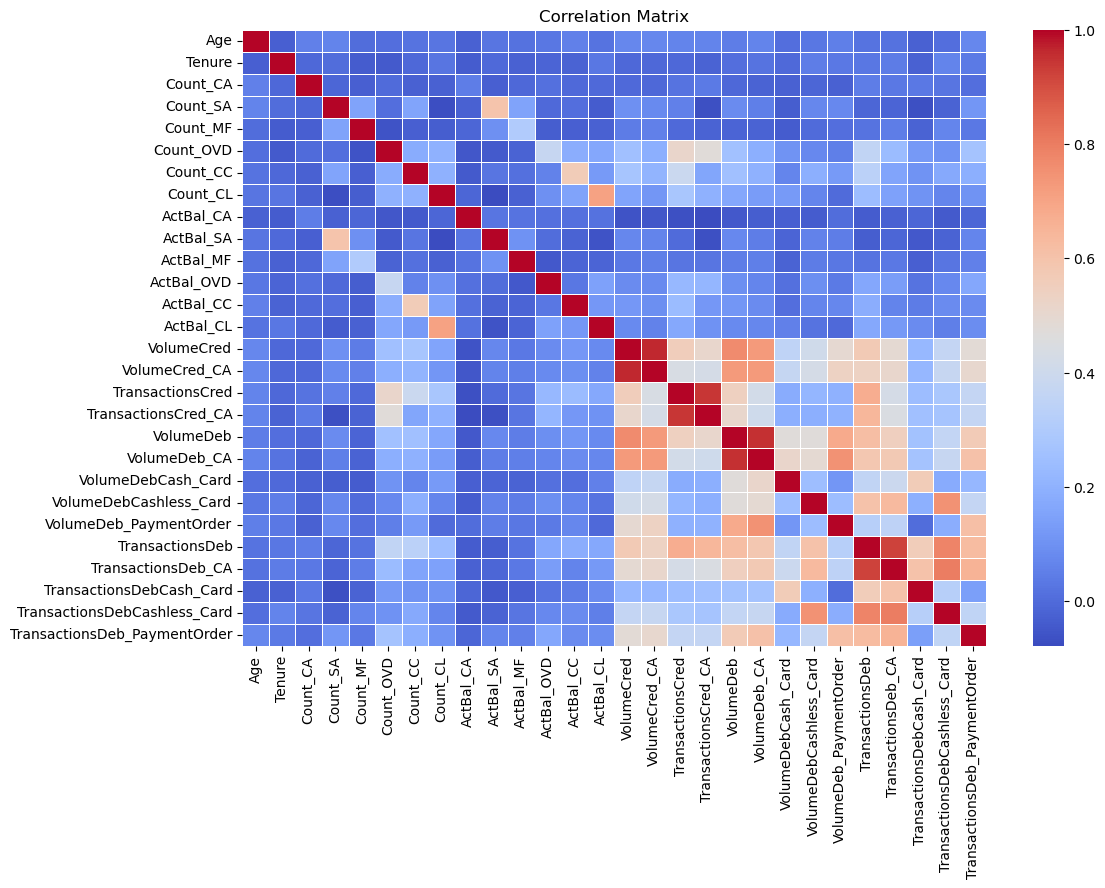

In [46]:
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()